In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf
abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_hartmann.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

config.sampler.conf.logger.do.online = False

dataset:
  grid_size: 10
  normalize_scores: true
  train_fraction: 1.0
  batch_size: 16384
  shuffle: true
  train_path: ~/activelearning/my_package/storage/hartmann/data_train.csv
  test_path: null
  _target_: activelearning.dataset.grid.HartmannDatasetHandler
oracle:
  _target_: activelearning.oracle.oracle.HartmannOracle
  fidelity: 1
  do_domain_map: true
  negate: false
sampler:
  _target_: activelearning.sampler.sampler.GreedySampler
  conf:
    agent:
      random_action_prob: 0.001
      optimizer:
        lr: 0.0005
        n_train_steps: 5000
    logger:
      do:
        online: true
      project_name: test_hartmann_gflownet
      run_name: identity_lr5e-4 newdata
    env:
      length: 10
      n_dim: 6
      cell_min: -1
      cell_max: 1
    proxy:
      reward_func: power
      reward_min: 1.0e-08
      reward_function_kwargs:
        beta: 1.0
selector:
  _target_: activelearning.selector.selector.Selector
surrogate:
  _target_: activelearning.surrogate.gp_surrogate.S

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_hartmann.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [2]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = config.device
n_iterations = config.budget  # TODO: replace with budget
grid_size = config.dataset.grid_size
n_samples = config.n_samples

from gflownet.utils.common import set_float_precision
float_prec = config.float_precision
# float_prec = set_float_precision(config.float_precision)

import matplotlib.colors as cm
import matplotlib.pyplot as plt
# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

In [3]:
from activelearning.dataset.grid import HartmannDatasetHandler
from activelearning.utils.logger import WandBLogger, ConsoleLogger
from activelearning.utils.plotter import ProjectionPlotHelper


# Dataset
dataset_handler = HartmannDatasetHandler(
    grid_size=grid_size,
    train_path="./data/hartmann/data_train.csv",
    train_fraction=1.0,
    float_precision=float_prec,
)
candidate_set, xi, yi = dataset_handler.get_candidate_set(step=1, as_dataloader=True)
plot_set, _, _ = dataset_handler.get_candidate_set(step=2, as_dataloader=False)

logger = WandBLogger(project_name="test_hartmann_plots", run_name="GreedySampler")
# logger = None
# logger = ConsoleLogger(project_name="test_hartmann", run_name="Greedy 10")

# plotter = None
# plotter = ProjectionPlotHelper(plot_set[:])
plotter = ProjectionPlotHelper(plot_set[:])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can

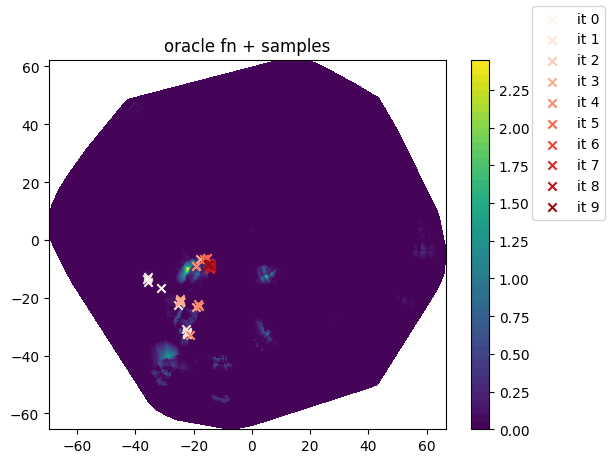

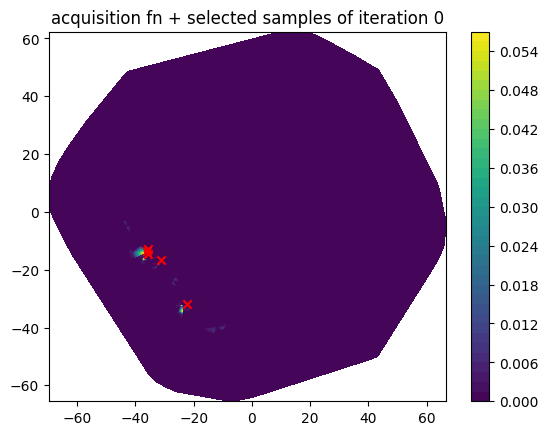

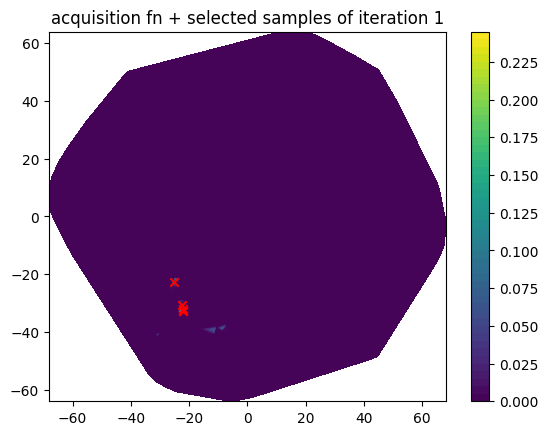

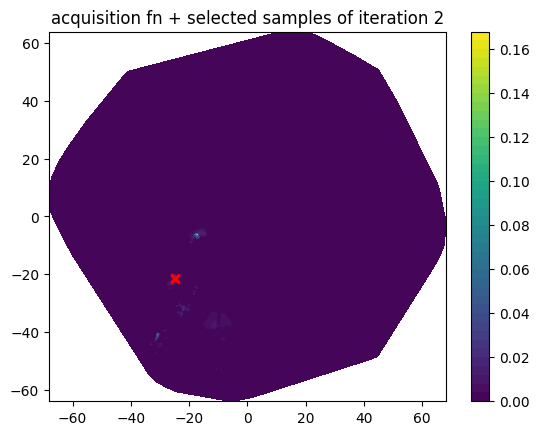

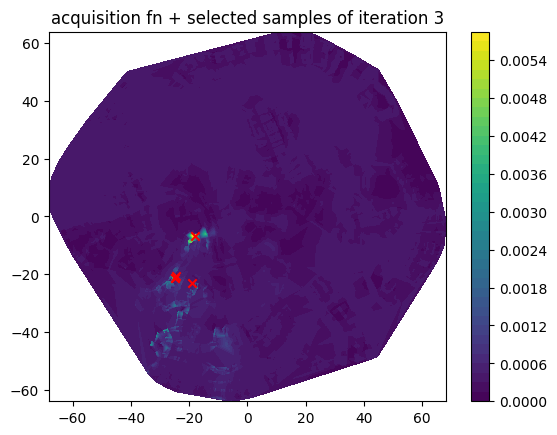

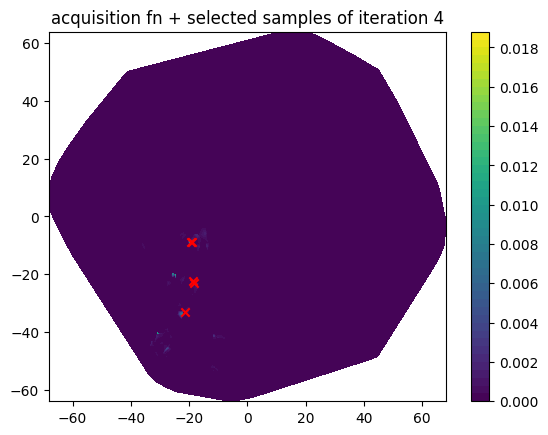

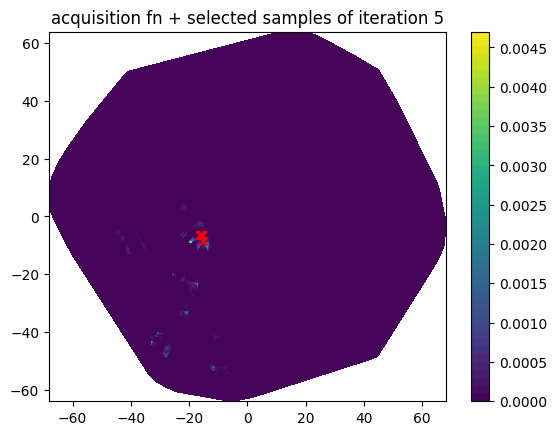

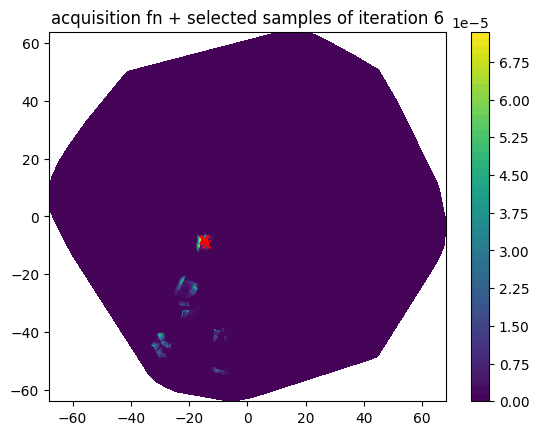

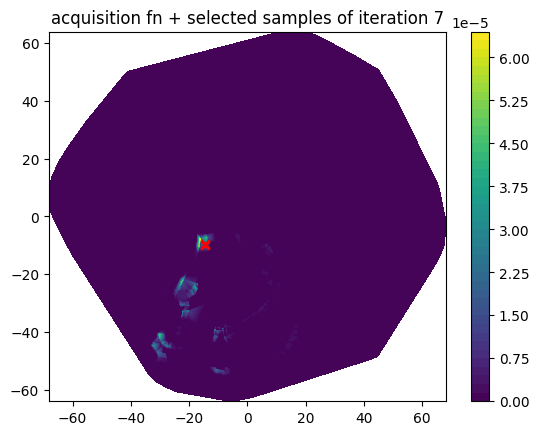

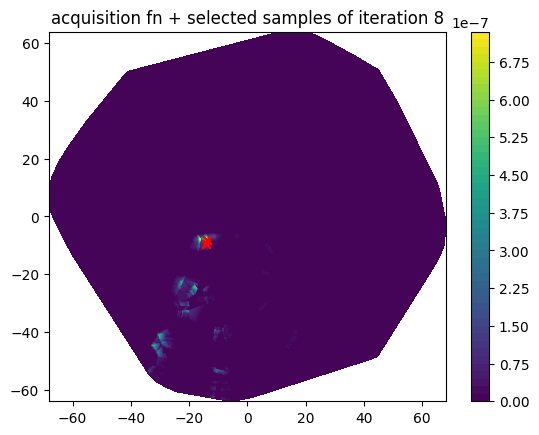

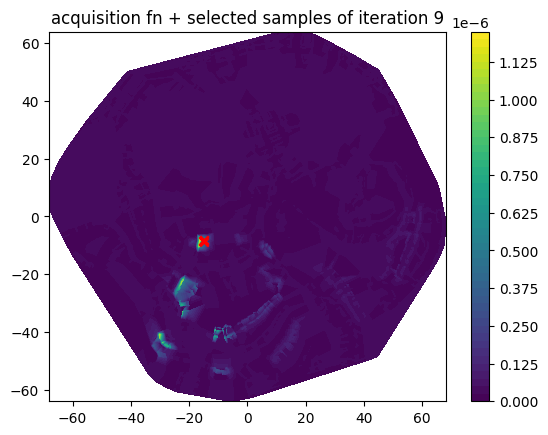

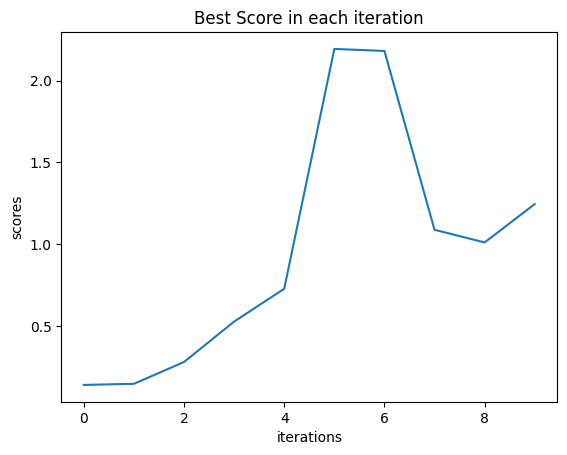

In [4]:
from activelearning.surrogate.gp_surrogate import SingleTaskGPRegressor
from activelearning.acquisition.acquisition import BOTorchMaxValueEntropyAcquisition
from activelearning.sampler.sampler import GreedySampler, RandomSampler
from activelearning.selector.selector import Selector, ScoreSelector
from activelearning.oracle.oracle import HartmannOracle

# Oracle
oracle = HartmannOracle(fidelity=1, device=device, float_precision=float_prec)

if plotter is not None:
    fig_oracle, ax_oracle = plotter.plot_function(oracle)


best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(
        device=device,
        float_precision=float_prec,
    )
    surrogate.fit(train_data)

    acq_fn = BOTorchMaxValueEntropyAcquisition(
        surrogate.model,
        device=device,
        float_precision=float_prec,
    )

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(
    #     acq_fn,
    # )
    sampler = GreedySampler(
        acquisition=acq_fn,
        device=device,
        float_precision=float_prec,
    )
    # sampler = hydra.utils.instantiate(
    #     config.sampler,
    #     acquisition=acq_fn,
    #     device=device,
    #     float_precision=float_prec,
    #     _recursive_=False,
    # )

    sampler.fit()  # only necessary for samplers that train a model

    samples, _ = sampler.get_samples(n_samples * 5, candidate_set=candidate_set)

    if plotter is not None and hasattr(sampler, "sampler"):

        def reward_fn(samples):
            return sampler.sampler.proxy.proxy2reward(sampler.sampler.proxy(samples))

        fig_reward, ax_reward = plotter.plot_function(reward_fn)
        fig_reward, ax_reward = plotter.plot_samples(samples, ax_reward, fig_reward)
        ax_reward.set_title("reward fn + proposed samples of iteration %i" % i)
        logger.log_figure(fig_reward, "reward")

    # Selector
    # selector = Selector()
    selector = ScoreSelector(
        acq_fn,
        device=device,
        float_precision=float_prec,
        maximize=True,
    )
    filtered_samples, _ = selector(n_samples=n_samples, candidate_set=samples.clone())

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_function(acq_fn)
        fig_acq, ax_acq = plotter.plot_samples(filtered_samples, ax_acq, fig_acq)
        ax_acq.set_title("acquisition fn + selected samples of iteration %i" % i)
        logger.log_figure(fig_acq, "acq")

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_samples(
            filtered_samples,
            ax_oracle,
            fig_oracle,
            c=cm.to_hex(colors(i / n_iterations)),
            label="it %i" % i,
        )

    del surrogate
    del sampler
    del selector

    scores = oracle(filtered_samples.clone())
    scores = dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.max().cpu())
    if logger is not None:
        logger.log_metric(scores.max().cpu(), "best_score")

if plotter is not None:
    fig_oracle.legend()
    ax_oracle.set_title("oracle fn + samples")
    logger.log_figure(fig_oracle, key="oracle")


fig = plt.figure()
plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")
if logger is not None:
    logger.log_figure(fig, key="best_scores")

In [3]:
from activelearning.dataset.grid import HartmannDatasetHandler


# Dataset
dataset_handler = HartmannDatasetHandler(
    grid_size=10,
    train_path="./data/hartmann/data_train.csv",
    train_fraction=1.0,
    float_precision=32,
)

In [4]:
from activelearning.oracle.oracle import HartmannOracle
oracle = HartmannOracle(fidelity=1, device="cpu", float_precision=32)

In [8]:
x, y = dataset_handler.train_data[:]
x

tensor([[-0.4000, -0.2000, -0.8000,  0.8000, -1.0000, -0.6000],
        [-0.2000, -0.6000, -1.0000,  0.2000,  0.6000, -0.6000],
        [ 0.4000, -0.6000, -1.0000, -0.2000,  0.0000,  0.8000],
        [ 0.0000,  0.2000, -0.8000, -1.0000, -0.4000,  0.6000],
        [-0.6000,  0.2000,  0.0000, -0.2000, -0.6000, -0.6000],
        [-0.4000,  0.6000,  0.6000,  0.8000,  0.0000, -1.0000],
        [ 0.6000, -0.4000, -0.4000, -0.4000, -0.4000,  0.6000],
        [-0.4000, -0.8000,  0.2000, -0.2000, -0.8000,  0.0000],
        [-0.6000, -1.0000,  0.8000, -0.6000, -0.6000,  0.2000],
        [-0.6000, -0.2000, -0.4000, -0.4000,  0.0000,  0.6000],
        [-0.6000, -0.4000,  0.2000,  0.0000, -0.6000,  0.4000],
        [ 0.0000,  0.6000,  0.8000,  0.4000,  0.2000, -0.6000],
        [-0.4000, -0.2000,  0.2000, -0.2000, -0.2000,  0.2000],
        [ 0.0000,  0.6000, -0.6000, -0.2000,  0.6000, -1.0000],
        [ 0.0000, -0.8000,  0.2000, -0.4000, -0.4000,  0.2000],
        [-0.2000,  0.8000, -0.2000, -0.2

In [23]:
oracle(x)

tensor([6.9138e-12, 6.3033e-09, 2.9070e-04, 3.4004e-12, 8.1035e-12, 8.0648e-12,
        4.9619e-07, 2.3959e-07, 7.2198e-08, 1.6322e-04, 4.8693e-06, 2.5948e-04,
        3.1359e-04, 6.5036e-11, 7.2960e-05, 1.3655e-09, 4.7255e-04, 4.9290e-10,
        4.7440e-10, 3.7299e-06, 3.1314e-06, 2.0790e-02, 1.9947e-06, 8.2647e-10,
        4.9141e-07])

In [13]:
oracle.get_max_reward()

tensor(3.3224)